# Machine Learning and Statistics for Physicists

## Homework 2

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [8]:
from sklearn import cluster, decomposition

In [9]:
from mls import locate_data
spectra_data = pd.read_hdf(locate_data('spectra_data.hf5'))

### Problem 1

The [Expectation-Maximization (EM) algorithm](https://en.wikipedia.org/wiki/Expectation-maximization_algorithm) is used to implement many machine learning methods, including K-means, factor analysis and weighted PCA.

The basic idea of EM is to optimize a goal function that depends on two disjoint sets of parameters by alternately updating one set and then the other, using a scheme that is guaranteed to improve the goal function (although generally to a local rather than global optimum). The alternating updates are called the E-step and M-step.

The K-means is one of the simplest uses of EM, so is a good way to get some hands-on experience.

Implement the function below to perform a K-means E-step. Hint: you might find [np.argmin](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argmin.html) useful.

The point of this exercise is to write a correct solution, rather than the fastest possible code. Therefore, feel free to use loops over array indices since they are usually easier to understand and get right than the equivalent vectorized numpy code. (You will get some practice writing vectorized code in the next question).

In [10]:
def E_step(X, centers):
    """Perform a K-means E-step.
    
    Assign each sample to the cluster with the nearest center, using the
    Euclidean norm to measure distance between a sample and a cluster center.
    
    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    centers : array with shape (n, D)
        Centers of the the n clusters in D dimensions.
        
    Returns
    -------
    integer array with shape (N,)
        Cluster index of each sample, in the range 0 to n-1.
    """
    N, D = X.shape
    n = len(centers)
    assert centers.shape[1] == D
    indices = np.empty(N, int)
    # YOUR CODE HERE
    Xexp = np.full((n,N,D),X)
    Xe = np.transpose(Xexp,(1,0,2))
    
    for i in range(N):
        indices[i]= np.argmin(np.linalg.norm((Xe[i]-centers),axis=1))
    #raise NotImplementedError()
    return indices



In [11]:
# A correct solution should pass these tests.
gen = np.random.RandomState(seed=123)
X = gen.normal(size=(20, 2))
centers = np.array([[0., 0.], [0., 10.]])
X[50:] += centers[1]
indices = E_step(X, centers)
assert np.all(indices[:50] == 0)
assert np.all(indices[50:] == 1)

centers = gen.uniform(size=(5, 2))
indices = E_step(X, centers)
assert np.array_equal(indices, [4, 1, 4, 4, 1, 0, 1, 0, 2, 1, 2, 4, 0, 1, 0, 1, 0, 1, 4, 4])

Next, implement the function below to perform a K-means M-step:

In [12]:
from scipy.stats import *
def M_step(X, indices, n):
    """Perform a K-means M-step.
    
    Calculate the center of each cluster as the geometric mean of its assigned samples.
    
    The centers of any clusters without any assigned samples should be set to the origin.
    
    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    indices : integer array with shape (N,)
        Cluster index of each sample, in the range 0 to n-1.
    n : int
        Number of clusters.  Must be <= N.
        
    Returns
    -------
    array with shape (n, D)
        Centers of the the n clusters in D dimensions.
    """
    N, D = X.shape
    assert indices.shape == (N,)
    assert n <= N
    centers = np.zeros((n, D))
    nsamp = np.zeros((n))
    arrmean = np.ones((n,D))
    """for i in range(N):
        for k in range(D):
            arrmean[indices[i],k]= arrmean[indices[i],k]*X[i,k]
        nsamp[indices[i]]=nsamp[indices[i]]+1
    
    for ii in range(n):
        if nsamp[ii]>0.5:
            for ij in range(D):
                centers[ii,ij]=arrmean[ii,ij] ** (1/nsamp[ii])
    """
    #centers= arrmean/np.transpose(np.full((D,n),nsamp),(2,0,1))
    # YOUR CODE HERE
    #raise NotImplementedError()
    for i in range(n):
        nar = []
        for j,k in enumerate(indices):
            if (k==i):
                nar.append(X[j])
        #print (np.transpose(nar))
        if (len(nar)==0):
            centers[i]=[0,0]
        else:
            
            for j in range(D):
                centers[i]=np.mean(nar,axis=0)
        
        
    #print (centers)
    
    return centers


In [13]:
# A correct solution should pass these tests.
gen = np.random.RandomState(seed=123)
X = np.ones((20, 2))
indices = np.zeros(20, int)
centers = M_step(X, indices, 1)
assert np.all(centers == 1.)

n = 5
indices = gen.randint(n, size=len(X))
centers = M_step(X, indices, n)
assert np.all(centers == 1.)

X = gen.uniform(size=X.shape)
centers = M_step(X, indices, n)
assert np.allclose(
    np.round(centers, 3),
    [[ 0.494,  0.381], [ 0.592,  0.645],
     [ 0.571,  0.371], [ 0.234,  0.634],
     [ 0.250,  0.386]])

You have now implemented the core of the K-means algorithm.  Try it out with this simple wrapper, which makes a scatter plot of the first two columns after each iteration. The sklearn wrapper combines the result of several random starting points and has other refinements.

In [14]:
def KMeans_fit(data, n_clusters, nsteps, seed=123):
    X = data.values
    N, D = X.shape
    assert n_clusters <= N
    gen = np.random.RandomState(seed=seed)
    # Pick random samples as the initial centers.
    shuffle = gen.permutation(N)
    centers = X[shuffle[:n_clusters]]
    # Perform an initial E step to assign samples to clusters.
    indices = E_step(X, centers)
    # Loop over iterations.
    for i in range(nsteps):
        centers = M_step(X, indices, n_clusters)
        indices = E_step(X, centers)
    # Plot the result.
    cmap = np.array(sns.color_palette())
    plt.scatter(X[:, 0], X[:, 1], c=cmap[indices % len(cmap)])
    plt.scatter(centers[:, 0], centers[:, 1], marker='+', c='k', s=400, lw=5)
    plt.show()

Try it out on some randomly generated 2D data with 3 separate clusters (using the handy [make_blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)):

In [15]:
from sklearn.datasets.samples_generator import make_blobs
gen = np.random.RandomState(seed=123)
X, _ = make_blobs(500, 2, [[-3,-3],[0,3],[3,-3]], random_state=gen)
data = pd.DataFrame(X, columns=('x0', 'x1'))

For this simple test, you should find a good solution after two iterations:

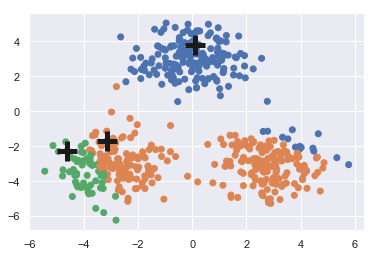

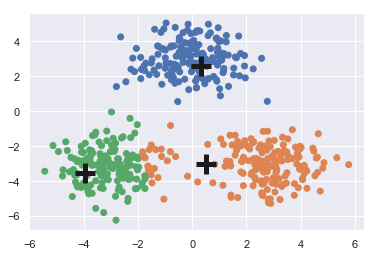

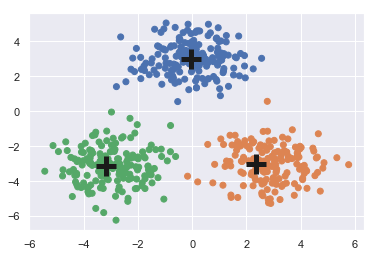

In [16]:
KMeans_fit(data, n_clusters=3, nsteps=0);
KMeans_fit(data, n_clusters=3, nsteps=1);
KMeans_fit(data, n_clusters=3, nsteps=2);

### Problem 2

The E step in the previous problem uses the separation matrix $S_{ij}$ between the $0 \le i < N$ ($D$-dimensional) samples $\mathbf{x}_i$ and the $0 \le i < n$ ($D$-dimensional) cluster means $\mathbf{\mu}_j$:
$$
S_{ij} \equiv \left| \mathbf{x}_i - \mathbf{\mu}_j \right|^2 \; .
$$
Note that this is a rectangular $N\times n$ matrix, so generally not square.

Implement the function below to calculate this matrix using PyTorch, with no explicit loops over tensor indices.

In [17]:
import torch

In [18]:
def S_matrix(X, mu):
    """Calculate the separation matrix used by the K-means E step.
    
    Calculate the 2D matrix S with elements |x[i] - mu[j]|^2 using
    PyTorch and no explicit loops.
    
    Parameters
    ----------
    X : torch tensor with shape (N, D)
        Input data consisting of N samples in D dimensions.
    mu : torch tensor with shape (n, D)
        Centers of the the n clusters in D dimensions.
    
    Returns
    -------
    array with shape (N, n)
    """
    N, D = X.size()
    n = len(mu)
    assert mu.shape[1] == D
    # YOUR CODE HERE
    a = X.unsqueeze(0)
    a = a.expand(n,N,D)
    b = mu.unsqueeze(0)
    b = b.expand(N,n,D)
    b = b.transpose(0,1)
    ab = a-b
    #ab = ab.transpose(1,2)
    ab = torch.norm(ab,dim=-1)**2
    ab = ab.transpose(0,1)
    
    #print (ab)
    #return torch.argmin(ab,dim=0)
    return ab
    raise NotImplementedError()

In [19]:
# A correct solution should pass these tests.
X = torch.zeros(5, 3)
mu = torch.ones(2, 3)
S = S_matrix(X, mu)
assert S.size() == (5, 2)
assert torch.allclose(S, torch.tensor(3.))

gen = np.random.RandomState(seed=123)
X = torch.tensor(gen.normal(size=(1000, 2)), dtype=torch.float32)
mu = torch.tensor([[0., 0.], [0., 10.]])
X[50:] += mu[1]
S = S_matrix(X, mu)
assert S.size() == (1000, 2)
assert torch.allclose(torch.mean(S, dim=0), torch.tensor([96.8427, 6.9882]))

### Problem 3

The PCA method of dimensionality reduction first calculates an exact linear decomposition (up to round off error),
then trims rows and columns to the desired number of latent variables.  In this problem, you will explore how PCA is implemented. The tricky linear algebra is already implemented in [numpy.linalg](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.linalg.html), but it is still a challenge to keep all the notation and conventions self consistent.

The input data $X$ is provided as an $N\times D$ (samples, features) matrix. In the following we assume that each feature is centered on zero (otherwise, calculate and subtract the $\mu_j$, then add them back later),
$$
\mu_j = \sum_i X_{ij} = 0 \;.
$$
There are three equivalent methods for performing the initial exact decomposition:
1. Calculate the $D\times D$ [sample covariance matrix](https://en.wikipedia.org/wiki/Sample_mean_and_covariance#Sample_covariance)
$$
C \equiv \frac{1}{N-1}\,X^T X \;.
$$
then find its eigenvalue decomposition:
$$
C = Q^T \Lambda Q
$$
where $\Lambda$ is a diagonal $D\times D$ matrix of eigenvalues and the rows of the orthogonal $D\times D$ matrix $Q$ are the corresponding eigenvectors.
2. Calculate the $N\times N$ matrix of dot products between samples:
$$
D \equiv \frac{1}{N-1}\,X X^T \;,
$$
then find its eigenvalue decomposition, where now $Q$ and $\Lambda$ are $N\times N$ matrices.
3. Find the [singular value decomposition (SVD)](https://en.wikipedia.org/wiki/Singular-value_decomposition) of $X$
$$
X = U S V \quad \Rightarrow \quad C = \frac{1}{N-1}\,V^T S^2 V \;,
$$
where $S$ is a diagonal $K\times K$ matrix of *singular values*, $U$ is $N\times K$ and $V$ is $K\times D$, with
$K = \min(N, D)$. The notation above is chosen to match [np.linalg.svd](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html) which you will use below.

The computational cost of each method depends differently on the values of $N$ and $D$, so the most efficient method will depend on the shape of the input data $X$. There are also numerical considerations: the matrices $C$ and $D$ should be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix) in order to guarantee positive eigenvalues, but this will not be true for $C$ if $N < D$ or for $D$ if $N > D$.

Implement the function below to calculate the eigenvectors and eigenvalues of a square input matrix using a suitable function from [np.linalg](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.linalg.html).  The results should be sorted in order of decreasing eigenvalues, as needed by PCA. Hint: `M[::-1]` reverses the rows of a 2D array `M` (more info [here](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html#indexing-slicing-and-iterating)).

In [20]:
def eigensolve(M):
    """Calculate eigenvectors and eigenvalues of a square symmetric matrix.
    
    Results are sorted by decreasing eigenvalue. The rows (not columns) of the
    returned eigenvector array are the normalized eigenvectors of M.
    
    Parameters
    ----------
    M : 2D array
        N x N symmetric square matrix to use.
        
    Returns
    -------
    tuple
        Tuple of arrays (eigenvalues, eigenvectors) with eigenvalues decreasing and
        eigenvector[i] corresponding to eigenvalue[i].  Eigenvalues should have the
        shape (N,) and eigenvectors should have the shape (N, N).
    """
    assert len(M.shape) == 2
    nrows, ncols = M.shape
    assert nrows == ncols
    assert np.all(M.T == M)
    w,v = np.linalg.eig(M)
    sortkey = np.argsort(w)[::-1]
    wo = np.array(w[sortkey])
    vo = np.array(np.transpose(v[:,sortkey]))
    
    return wo,vo
    raise NotImplementedError()

In [21]:
# A correct solution should pass the tests below.
C = np.diag(np.arange(1., 5.))
evals, evecs = eigensolve(C)
assert np.allclose(
    evals,
    [ 4.,  3.,  2.,  1.])
assert np.allclose(
    evecs,
    [[ 0.,  0.,  0.,  1.],
     [ 0.,  0.,  1.,  0.],
     [ 0.,  1.,  0.,  0.],
     [ 1.,  0.,  0.,  0.]])

gen = np.random.RandomState(seed=123)
N, D = 4, 3
X = gen.uniform(size=(N, D))
X -= np.mean(X, axis=0)
C = np.dot(X.T, X) / (N - 1)
evals, evecs = eigensolve(C)
assert np.allclose(C, evecs.T.dot(np.diag(evals).dot(evecs)))
assert np.allclose(
    np.round(evals, 5),
    [ 0.08825,  0.0481 ,  0.01983])
assert np.allclose(
    np.round(evecs, 3),
    [[-0.787, -0.477,  0.391],
     [-0.117,  0.737,  0.665],
     [-0.606,  0.478, -0.636]])

Implement the function below to calculate the same quantities using the [SVD method](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html) directly on $X$ instead of solving the eigenvalue problem for the sample covariance.  Hint: pay attention to the `full_matrices` parameter.

In [22]:
def svdsolve(X):
    """Calculate eigenvectors and eigenvalues of the sample covariance of X.

    Results are sorted by decreasing eigenvalue. The rows (not columns) of the
    returned eigenvector array are the normalized eigenvectors of M.

    Uses the SVD method directly on X.
    
    Parameters
    ----------
    X: 2D array
        N x D matrix to use.
        
    Returns
    -------
    tuple
        Tuple of arrays (eigenvalues, eigenvectors) with eigenvalues decreasing and
        eigenvector[i] corresponding to eigenvalue[i].  Eigenvalues should have the
        shape (K,) and eigenvectors should have the shape (K, D) with K=min(N, D).
    """
    assert len(X.shape) == 2
    N, D = X.shape
    # YOUR CODE HERE
    u,s,v = np.linalg.svd(X,full_matrices=False)
    ss = s**2 /(N-1)
    return ss, v
    raise NotImplementedError()


In [23]:
# A correct solution should pass the tests below.
gen = np.random.RandomState(seed=123)
N, D = 4, 3
X = gen.uniform(size=(N, D))
X -= np.mean(X, axis=0)
evals, evecs = svdsolve(X)
C = np.dot(X.T, X) / (N - 1)
assert np.allclose(C, evecs.T.dot(np.diag(evals).dot(evecs)))
assert np.allclose(
    np.round(evals, 5),
    [ 0.08825,  0.0481 ,  0.01983])
assert np.allclose(
    np.round(evecs, 3),
    [[-0.787, -0.477,  0.391],
     [ 0.117, -0.737, -0.665],
     [ 0.606, -0.478,  0.636]])

N, D = 3, 4
X = gen.uniform(size=(N, D))
X -= np.mean(X, axis=0)
evals, evecs = svdsolve(X)
C = np.dot(X.T, X) / (N - 1)
assert np.allclose(C, evecs.T.dot(np.diag(evals).dot(evecs)))
assert np.allclose(
    np.round(evals, 5),
    [ 0.23688,  0.03412,  0.     ])
assert np.allclose(
    np.round(evecs, 3),
    [[ 0.368,  0.874,  0.316, -0.041],
     [ 0.752, -0.178, -0.313,  0.553],
     [-0.475,  0.445, -0.62 ,  0.439]])

Note that the eigenvectors found by the two methods might differ by an overall sign, but both sets of eigenvectors are orthonormal, so equally valid.

The following simple driver code shows how to build a PCA fit from your functions (but the [sklearn driver](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) has a lot more options):

In [24]:
def PCA_fit(data, n_components=2):
    X = data.values
    N, D = X.shape
    print('N,D = {},{}'.format(N, D))
    K = min(N, D)
    assert n_components <= K
    # Subtract mean value of each feature.
    mu = np.mean(X, axis=0)
    Xc = X - mu
    # Select the method based on N, D.
    if N > 2 * D:
        print('Using method 1')
        evals, M = eigensolve(np.dot(Xc.T, Xc) / (N - 1))
        assert evals.shape == (D,) and M.shape == (D, D)
    elif D > 2 * N:
        print('Using method 2')
        evals, M = eigensolve(np.dot(Xc, Xc.T) / (N - 1))
        assert evals.shape == (N,) and M.shape == (N, N)
        # Eigenvectors are now M = U.T of the SVD.  Convert to M = V.
        # Use abs(evals) since smallest values might be < 0 due to numerical errors.
        M = np.dot(np.dot(np.diag(np.abs(evals) ** -0.5), M), Xc) / np.sqrt(N - 1)
    else:
        print('Using method 3')
        evals, M = svdsolve(Xc)
        assert evals.shape == (K,) and M.shape == (K, D)
    # Calculate Y such that Xc = Y M.
    Y = np.dot(Xc, M.T)
    # Trim to latent variable subspace.
    Y = Y[:, :n_components]
    M = M[:n_components]
    # Calculate reconstructed samples.
    Xr = np.dot(Y, M) + mu
    # Plot some samples and their reconstructions.
    for i,c in zip((0, 6, 7), sns.color_palette()):
        plt.plot(X[i], '.', c=c, ms=5)
        plt.plot(Xr[i], '-', c=c)
    plt.show()

Test this driver in each regime by varying the number of features used from `spectra_data` with $N$, $D$ = 200, 500:
- $N \gg D$: method 1
- $N \ll D$: method 2
- $N \simeq D$: method 3

N,D = 200,40
Using method 1


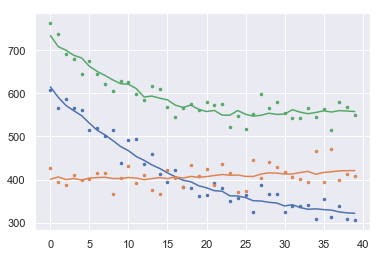

In [25]:
PCA_fit(spectra_data.iloc[:, 190:230], n_components=2)

N,D = 200,500
Using method 2


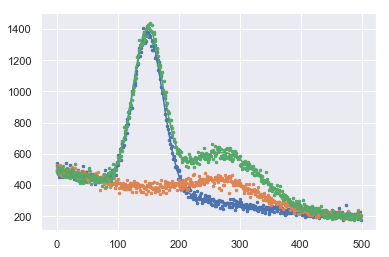

In [26]:
PCA_fit(spectra_data, n_components=2)

N,D = 200,200
Using method 3


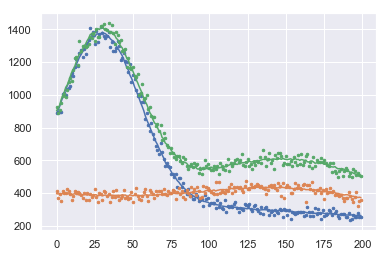

In [27]:
PCA_fit(spectra_data.iloc[:, 120:320], n_components=2)